In [1]:
import numpy as np
# hide numpy log warning
np.seterr(divide = 'ignore') 
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

from skbio import OrdinationResults
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (precision_recall_curve, auc)
from statannotations.Annotator import Annotator
from biom import load_table

# hide pandas Future/Deprecation Warning(s) for tutorial
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.simplefilter(action='ignore', category=FutureWarning)
# plotting
plt.style.use('ggplot')
sns.set_style('white')
%matplotlib inline

In [2]:
#load rpca results
ord_18S = OrdinationResults.read('../results/joint-rpca/18S_ord.txt')
ord_mag = OrdinationResults.read('../results/joint-rpca/mag_ord.txt')
ord_gene = OrdinationResults.read('../results/joint-rpca/gene_ord.txt')
ord_gene_module = OrdinationResults.read('../results/joint-rpca/gene_module_ord.txt')
ord_metabolite = OrdinationResults.read('../results/joint-rpca/metabolite_ord.txt')
#load joint-rpca results
ord_joint = OrdinationResults.read('../results/joint-rpca/joint_ord.txt')
#load shared metadata
metadata = pd.read_csv('../network/split-matched-data/metadata_knn.tsv', index_col=0, sep='\t')

In [3]:
print(metadata.shape)
display(metadata.head())

(374, 16)


,season,subjects,add_0c,add_0c_group,facility,timepoint,traintest_0,traintest_1,traintest_2,traintest_3,traintest_4,traintest_5,traintest_6,traintest_7,traintest_8,traintest_9
sample_name,,,,,,,,,,,,,,,,
soil.hip.CMU.17.10.2017.08.11.day3,summer,17-10,49.75,early,FIRS,3,train,train,train,test,train,test,test,test,train,train
soil.hip.CMU.17.10.2017.08.22.day14,summer,17-10,322.80,advanced,FIRS,14,test,train,train,train,test,train,train,train,test,train
soil.hip.CMU.17.10.2017.08.28.day20,summer,17-10,477.80,advanced,FIRS,20,train,test,train,train,test,train,test,train,train,train
soil.hip.CMU.17.10.2017.08.09.day1,summer,17-10,0.00,initial,FIRS,1,test,train,train,train,train,train,train,train,train,test
soil.hip.CMU.17.10.2017.08.23.day15,summer,17-10,348.05,advanced,FIRS,15,train,train,train,test,train,train,test,train,train,train


### KNN with subject ordinations

In [4]:
## NEED TO RUN ONLY ONCE
# create and save new set of train-test splits
# for i_ in range(10):
#     train, test = train_test_split(metadata, test_size=0.25, shuffle=True, random_state=i_,
#                                    stratify=metadata[['facility']])
#     metadata.loc[:, 'traintest_%i' % i_] = 'train'
#     metadata.loc[test.index, 'traintest_%i' % i_] = 'test'

# display(metadata.head())
# save data 
#metadata.to_csv('../network/split-matched-data/metadata_knn.tsv', sep='\t')

In [4]:
display(ord_18S.samples.head())
display(ord_18S.features.head())

,0,1,2
soil.hip.CMU.17.04.2017.03.day15,0.002188,0.039359,-0.164453
soil.hip.SHSU.2017.043.2017.12.16.day17,0.059914,0.021963,0.033121
soil.hip.SHSU.2016.024.2016.04.20.day6,0.055458,0.032975,0.032816
soil.hip.UTK.K016.06.2016.10.25.day21,-0.078864,-0.046812,-0.017351
soil.hip.UTK.K016.03.2016.05.08.day3,0.051180,0.030832,0.017551


,0,1,2
1ecabeadc650c7766977f8aaf109a428,0.002161,-0.000917,0.001578
b4489cfd6bb0c8998d06917443dc3b3a,-0.001020,0.002025,0.000342
e8bcf4ec58f8288f6deb74c09ddb1a6e,-0.002175,-0.000118,-0.001337
100af6a31edf765d18a9815dbc3c3f97,0.002355,0.007000,0.000970
34caeb0031628a6bf9d44820b5ba1269,0.003071,0.006529,0.007070


In [6]:
def knn_apr(ord_tables, ord_ids, shared_mt, cat_of_interest):

    #initialize dataframe to store results
    metrics_df = pd.DataFrame(columns=['AUC_APR', 'Group', 'Fold', 'Omic'])
    apr_ord = {}
    #iterate over ordination tables
    for ord, omic in zip(ord_tables, ord_ids):
        #set up the classifier
        knn = KNeighborsClassifier(n_neighbors=5)
        X = ord.samples.copy()
        y = X.index.map(shared_mt[cat_of_interest])
        #iterate over folds
        apr_fold = {}
        for fold in ['traintest_{}'.format(i) for i in range(10)]:

            X_group = X.index.map(shared_mt[fold])
            train_index = [True if x == 'train' else False for x in X_group]
            test_index = [True if x == 'test' else False for x in X_group]
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            knn.fit(X_train.values, y_train)
            y_proba = knn.predict_proba(X_test)

            apr_cat = {}
            for cat in y.unique():
                precision, recall, _ = precision_recall_curve(y_test, y_proba[:,0],
                                                              pos_label=cat)
                #PR AUC
                apr = auc(x=recall, y=precision)
                apr_cat[cat] = apr
            apr_fold[fold] = apr_cat
        apr_ord[omic] = apr_fold

    #create df with metrics
    for omic, apr_fold in apr_ord.items():
        for fold, apr_cat in apr_fold.items():
            for cat, apr in apr_cat.items():
                metrics_df = metrics_df.append({'AUC_APR': apr, 'Group': cat,
                                                'Fold': fold, 'Omic': omic}, ignore_index=True)
    return metrics_df

In [7]:
apr_ord_facility = knn_apr(ord_tables=[ord_18S, ord_mag, ord_gene, 
                                       ord_gene_module, ord_metabolite, ord_joint],
                           ord_ids=["18S_RPCA", "MAG_RPCA", "Gene_RPCA",
                                    "Gene_Module_RPCA", "Metabolite_RPCA", "Joint_RPCA"],
                           shared_mt=metadata, cat_of_interest='facility')
display(apr_ord_facility.head())

,AUC_APR,Group,Fold,Omic
0,0.085689,FIRS,traintest_0,18S_RPCA
1,0.214322,STAFS,traintest_0,18S_RPCA
2,0.942404,ARF,traintest_0,18S_RPCA
3,0.162823,FIRS,traintest_1,18S_RPCA
4,0.213127,STAFS,traintest_1,18S_RPCA


In [8]:
apr_ord_stage = knn_apr(ord_tables=[ord_18S, ord_mag, ord_gene, 
                                    ord_gene_module, ord_metabolite, ord_joint],
                        ord_ids=["18S_RPCA", "MAG_RPCA", "Gene_RPCA", 
                                 "Gene_Module_RPCA", "Metabolite_RPCA", "Joint_RPCA"],
                        shared_mt=metadata, cat_of_interest='add_0c_group')
display(apr_ord_stage.head())

,AUC_APR,Group,Fold,Omic
0,0.386468,advanced,traintest_0,18S_RPCA
1,0.497687,active,traintest_0,18S_RPCA
2,0.122561,early,traintest_0,18S_RPCA
3,0.033525,initial,traintest_0,18S_RPCA
4,0.302510,advanced,traintest_1,18S_RPCA


In [9]:
apr_ord_season = knn_apr(ord_tables=[ord_18S, ord_mag, ord_gene, 
                                     ord_gene_module, ord_metabolite, ord_joint],
                         ord_ids=["18S_RPCA", "MAG_RPCA", "Gene_RPCA",  
                                  "Gene_Module_RPCA", "Metabolite_RPCA", "Joint_RPCA"],
                         shared_mt=metadata, cat_of_interest='season')
display(apr_ord_season.head())

,AUC_APR,Group,Fold,Omic
0,0.102246,winter,traintest_0,18S_RPCA
1,0.148936,spring,traintest_0,18S_RPCA
2,0.914171,fall,traintest_0,18S_RPCA
3,0.329575,summer,traintest_0,18S_RPCA
4,0.116067,winter,traintest_1,18S_RPCA


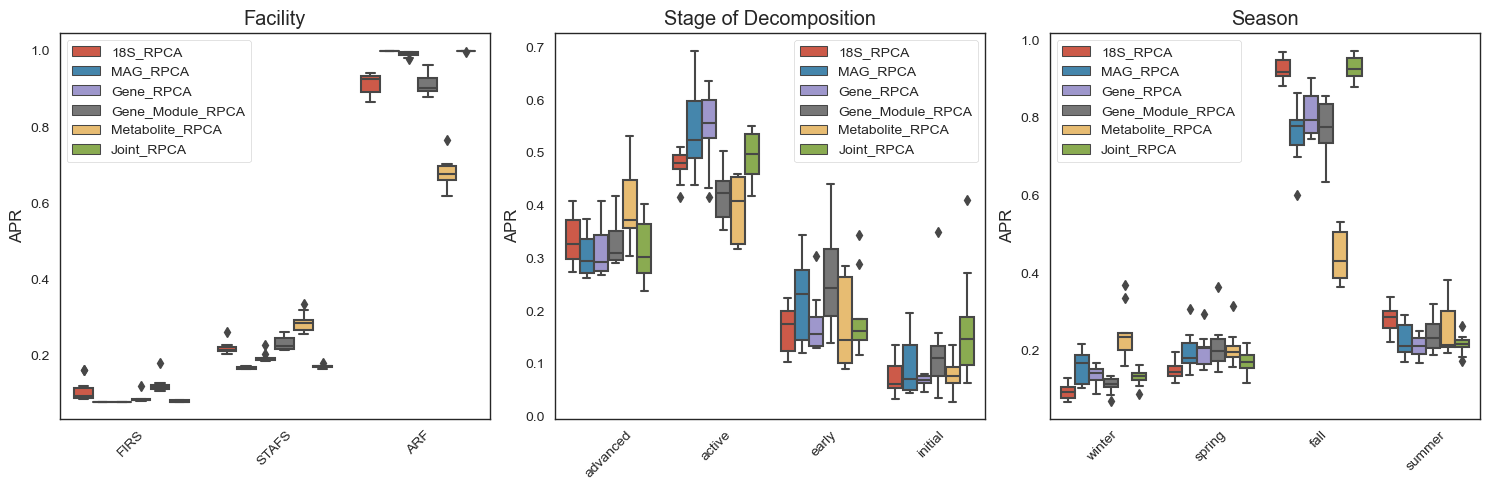

In [10]:
#seaborn boxplot
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.boxplot(data=apr_ord_facility, x='Group', y='AUC_APR', hue='Omic', ax=ax[0])
sns.boxplot(data=apr_ord_stage, x='Group', y='AUC_APR', hue='Omic', ax=ax[1])
sns.boxplot(data=apr_ord_season, x='Group', y='AUC_APR', hue='Omic', ax=ax[2])
#x axis rotation
for a, title in zip(ax, ['Facility', 'Stage of Decomposition', 'Season']):
    a.set_xticklabels(a.get_xticklabels(), rotation=45)
    a.set_xlabel('')
    a.set_ylabel('APR')
    a.legend(loc='best')
    a.set_title(title)
plt.tight_layout()
plt.show()

In [11]:
apr_avg_facility = pd.DataFrame(columns=['Fold', 'Omic', 'AUC_APR'])
apr_avg_stage = pd.DataFrame(columns=['Fold', 'Omic', 'AUC_APR'])
apr_avg_season = pd.DataFrame(columns=['Fold', 'Omic', 'AUC_APR'])

for fold_ in ['traintest_{}'.format(i) for i in range(10)]:
    avg1 = apr_ord_facility[apr_ord_facility['Fold'] == fold_].groupby('Omic').mean()
    apr_avg_fac = pd.DataFrame(zip([fold_]*6, avg1.index, avg1['AUC_APR']),
                               columns=['Fold', 'Omic', 'AUC_APR'])
    apr_avg_facility = pd.concat([apr_avg_facility, apr_avg_fac])

    avg2 = apr_ord_stage[apr_ord_stage['Fold'] == fold_].groupby('Omic').mean()
    apr_avg_st = pd.DataFrame(zip([fold_]*6, avg2.index, avg2['AUC_APR']),
                              columns=['Fold', 'Omic', 'AUC_APR'])
    apr_avg_stage = pd.concat([apr_avg_stage, apr_avg_st])

    avg3 = apr_ord_season[apr_ord_season['Fold'] == fold_].groupby('Omic').mean()
    apr_avg_se = pd.DataFrame(zip([fold_]*6, avg3.index, avg3['AUC_APR']),
                              columns=['Fold', 'Omic', 'AUC_APR'])
    apr_avg_season = pd.concat([apr_avg_season, apr_avg_se])

/Users/bec5786/anaconda3/envs/qiime2-amplicon-2024.2/lib/python3.8/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/bec5786/anaconda3/envs/qiime2-amplicon-2024.2/lib/python3.8/site-packages/scipy/stats/_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Metabolite_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
Gene_Module_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:5.859e-03 Stat=2.000e+00
Gene_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
MAG_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:2.077e-02 Stat=3.000e+00
18S_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:1.602e-01 Stat=1.300e+01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Metabolite_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:9.766e-03 Stat=3.000e+00
Gene_Module_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), 

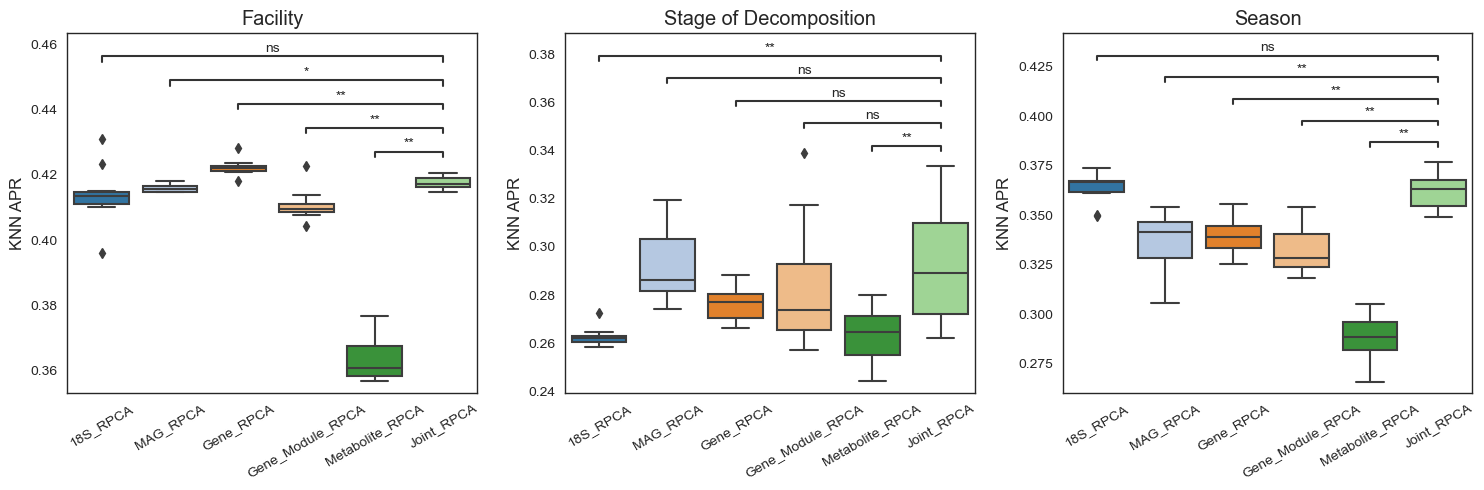

In [12]:
order = ['18S_RPCA', 'MAG_RPCA', 'Gene_RPCA', 
         'Gene_Module_RPCA', 'Metabolite_RPCA', 'Joint_RPCA']
stat_pairs = [(omic, "Joint_RPCA") for omic in order[0:-1]]
plotting_params = {'x':'Omic', 'y':'AUC_APR', 
                   'order':order, 'palette':'tab20'}

fig, axn = plt.subplots(1, 3, figsize=(15, 5))
for ax_, data, title in zip(axn.flatten(), 
                           [apr_avg_facility, apr_avg_stage, apr_avg_season],
                           ['Facility', 'Stage of Decomposition', 'Season']):
    
    plotting_params['data'] = data
    sns.boxplot(ax=ax_, **plotting_params)
    
    ax_.set_xticklabels(ax_.get_xticklabels(), rotation=30)
    ax_.set_xlabel('')
    ax_.set_ylabel('KNN APR')
    ax_.set_title(title)

    #add statistical test
    annotator = Annotator(ax_, stat_pairs, **plotting_params)
    annotator.configure(test="Wilcoxon").apply_and_annotate()
    #test options: Mann-Whitney, Kruskal, Wilcoxon

plt.tight_layout()
plt.show()

In [13]:
metadata_stage_binned = metadata.copy()
#join early/initial together and active/advanced together
metadata_stage_binned.loc[metadata_stage_binned['add_0c_group'] == 'early', 'add_0c_group'] = 'early/initial'
metadata_stage_binned.loc[metadata_stage_binned['add_0c_group'] == 'initial', 'add_0c_group'] = 'early/initial'
metadata_stage_binned.loc[metadata_stage_binned['add_0c_group'] == 'active', 'add_0c_group'] = 'active/advanced'
metadata_stage_binned.loc[metadata_stage_binned['add_0c_group'] == 'advanced', 'add_0c_group'] = 'active/advanced'

In [14]:
print(metadata.add_0c_group.value_counts())
print(metadata_stage_binned.add_0c_group.value_counts())

advanced    162
active      142
early        47
initial      23
Name: add_0c_group, dtype: int64
active/advanced    304
early/initial       70
Name: add_0c_group, dtype: int64


In [15]:
ord_stage_binned = knn_apr(ord_tables=[ord_18S, ord_mag, ord_gene, 
                                       ord_gene_module, ord_metabolite, ord_joint],
                           ord_ids=["18S_RPCA", "MAG_RPCA", "Gene_RPCA",  
                                    "Gene_Module_RPCA", "Metabolite_RPCA", "Joint_RPCA"],
                           shared_mt=metadata_stage_binned, cat_of_interest='add_0c_group')

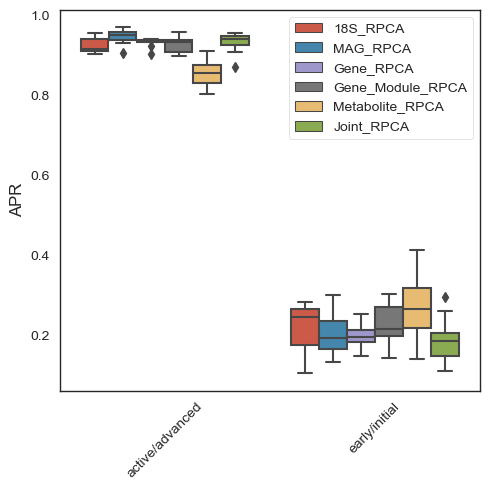

In [16]:
#seaborn boxplot
fig = plt.figure(figsize=(5, 5))
ax = plt.gca()
sns.boxplot(data=ord_stage_binned, x='Group', y='AUC_APR', hue='Omic')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_xlabel('')
ax.set_ylabel('APR')
ax.legend(loc='best')
plt.tight_layout()
plt.show()

In [17]:
apr_avg_stage_binned = pd.DataFrame(columns=['Fold', 'Omic', 'AUC_APR'])

for fold_ in ['traintest_{}'.format(i) for i in range(10)]:

    avg = ord_stage_binned[ord_stage_binned['Fold'] == fold_].groupby('Omic').mean()
    apr_avg_st = pd.DataFrame(zip([fold_]*6, avg.index, avg['AUC_APR']),
                              columns=['Fold', 'Omic', 'AUC_APR'])
    apr_avg_stage_binned = pd.concat([apr_avg_stage_binned, apr_avg_st])

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Metabolite_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:1.000e+00 Stat=2.700e+01
Gene_Module_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:1.309e-01 Stat=1.200e+01
Gene_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:5.566e-01 Stat=2.100e+01
MAG_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:6.445e-02 Stat=9.000e+00
18S_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:1.602e-01 Stat=1.300e+01


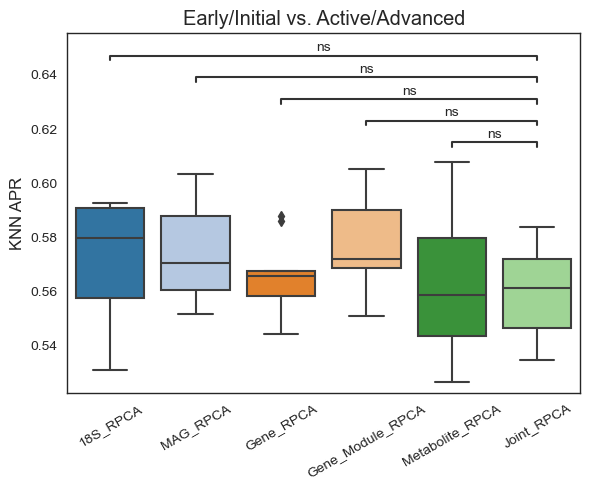

In [18]:
order = ['18S_RPCA', 'MAG_RPCA', 'Gene_RPCA', 
         'Gene_Module_RPCA', 'Metabolite_RPCA', 'Joint_RPCA']
stat_pairs = [(omic, "Joint_RPCA") for omic in order[0:-1]]

plotting_params = {'x':'Omic', 'y':'AUC_APR', 
                   'order':order, 'palette':'tab20',
                   'data':apr_avg_stage_binned}

fig = plt.figure(figsize=(6, 5))
ax_ = plt.gca()
sns.boxplot(ax=ax_, **plotting_params)
ax_.set_xticklabels(ax_.get_xticklabels(), rotation=30)
ax_.set_xlabel('')
ax_.set_ylabel('KNN APR')
ax_.set_title('Early/Initial vs. Active/Advanced')

#add statistical test
annotator = Annotator(ax_, stat_pairs, **plotting_params)
annotator.configure(test="Wilcoxon").apply_and_annotate()
#test options: Mann-Whitney, Kruskal, Wilcoxon

plt.tight_layout()
plt.show()

### KNN with top features and log-ratios

In [4]:
# import the rest
all_tables = {'18S':'../network/split-matched-data/18S.biom',
              'mag':'../network/split-matched-data/mag.biom',
              'gene':'../network/split-matched-data/gene.biom',
              'gene_module':'../network/split-matched-data/gene_module.biom',
              'metabolite':'../network/split-matched-data/metabolite.biom'}

tables = {}
for tbl_id, tbl_path in all_tables.items():
    tables[tbl_id] = load_table(tbl_path)

In [5]:
#retrieve feature loadings from joint-rpca
joint_features = ord_joint.features

#for 18S, need to make sure features are in the original table
not_in_ord_18S = []
in_ord_18S = []

for id in tables['18S'].ids(axis='observation'):
    if id not in joint_features.index:
        not_in_ord_18S.append(id)
    else:
        in_ord_18S.append(id)
print("Not in ordination results: %i" % len(not_in_ord_18S))
print("In ordination results: %i" % len(in_ord_18S))

#keep only common features
#tables['18S'] = tables['18S'].filter(ids_to_keep=in_ord_18S, axis='observation')
#3rpca_top_fts['18S'] = rpca_top_fts['18S'].loc[in_ord_18S]

Not in ordination results: 42
In ordination results: 5431


In [6]:
def get_top_features(table, ordination, 
                     component=['PC1'], quantile=0.90, 
                     pseudocount=0):
    
    #get the loadings
    floadings = ordination.copy()
    floadings.rename(columns={0:"PC1", 1:"PC2", 
                              2:"PC3", 3:"PC4"}, inplace=True)
    table_df = table.copy().to_dataframe()
    
    top_pc_values = {}
    bottom_pc_values = {}
    beta_l = {}
    
    #sort loadings along each component
    for pc in component:
        floadings.sort_values(by=pc, ascending=False, inplace=True)
        floadings_ = floadings[pc].copy()
        #get top and bottom loading quantiles
        top_q = floadings_.quantile(quantile)
        bottom_q = floadings_.quantile(1-quantile)
        top_fts = floadings_[floadings_ >= top_q].index
        bottom_fts = floadings_[floadings_ <= bottom_q].index
        #aggregate the top and bottom features per sample
        num = table_df.loc[top_fts].sum(axis=0)
        num += pseudocount
        top_pc_values[pc] = num.values
        denom = table_df.loc[bottom_fts].sum(axis=0)
        denom += pseudocount
        bottom_pc_values[pc] = denom.values
        #calculate trajectories
        beta_ = np.log(num).values - np.log(denom).values
        beta_l[pc] = beta_

    #save top and bottom features as df
    top_fts_df = pd.DataFrame(top_pc_values, index=num.index)
    bottom_fts_df = pd.DataFrame(bottom_pc_values, index=denom.index)
    #save trajectories as df
    beta_df = pd.DataFrame(beta_l, index=num.index)
    #drop any NaN or infinity values
    beta_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    beta_df.dropna(inplace=True)

    return top_fts_df, bottom_fts_df, beta_df

In [7]:
def knn_apr(ord_tables, ord_ids, shared_mt, cat_of_interest):

    metrics_df = pd.DataFrame(columns=['AUC_APR', 'Group', 'Fold', 'Omic'])
    apr_ord_facility = {}
    
    for ord, omic in zip(ord_tables, ord_ids):
        
        #set up the classifier
        knn = KNeighborsClassifier(n_neighbors=5)
        X = ord.copy()
        y = X.index.map(shared_mt[cat_of_interest])

        apr_fold = {}
        for fold in ['traintest_{}'.format(i) for i in range(10)]:

            X_group = X.index.map(shared_mt[fold])
            train_index = [True if x == 'train' else False for x in X_group]
            test_index = [True if x == 'test' else False for x in X_group]

            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            knn.fit(X_train.values, y_train)
            y_proba = knn.predict_proba(X_test)

            apr_cat = {}
            for cat in y.unique():
                precision, recall, _ = precision_recall_curve(y_test, y_proba[:,0],
                                                              pos_label=cat)
                #PR AUC
                apr = auc(x=recall, y=precision)
                apr_cat[cat] = apr

            apr_fold[fold] = apr_cat
        apr_ord_facility[omic] = apr_fold

    #create df with metrics
    for ord, apr_fold in apr_ord_facility.items():
        for fold, apr_cat in apr_fold.items():
            for cat, apr in apr_cat.items():
                metrics_df = metrics_df.append({'AUC_APR': apr, 'Group': cat,
                                                'Fold': fold, 'Omic': ord}, ignore_index=True)
                
    return metrics_df

### Top features

In [21]:
rpca_ord = {'18S': ord_18S, 'mag': ord_mag, 'gene': ord_gene, 
            'gene_module': ord_gene_module, 'metabolite': ord_metabolite}
quantile = 0.90
pcs_to_use = ['PC3']#['PC1', 'PC2', 'PC3']
rpca_top_fts = {}
rpca_bottom_fts = {}

for omic in tables.keys():

    ord_ = rpca_ord[omic].features.copy()
    table_ = tables[omic]

    top_fts, bottom_fts, beta_l = get_top_features(table_, ord_, component=pcs_to_use,
                                                   quantile=quantile, pseudocount=0)
    rpca_top_fts[omic] = top_fts
    rpca_bottom_fts[omic] = bottom_fts

In [22]:
#retrieve feature loadings from joint-rpca
joint_features = ord_joint.features

#for 18S, need to make sure features are in the original table
not_in_ord_18S = []
in_ord_18S = []

for id in tables['18S'].ids(axis='observation'):
    if id not in joint_features.index:
        not_in_ord_18S.append(id)
    else:
        in_ord_18S.append(id)
print("Not in ordination results: %i" % len(not_in_ord_18S))
print("In ordination results: %i" % len(in_ord_18S))

#keep only common features
#tables['18S'] = tables['18S'].filter(ids_to_keep=in_ord_18S, axis='observation')
#3rpca_top_fts['18S'] = rpca_top_fts['18S'].loc[in_ord_18S]

Not in ordination results: 42
In ordination results: 5431


In [23]:
#find top features from joint-RPCA ordination results
joint_rpca_top_fts = {}
joint_rpca_bottom_fts = {}

for omic in tables.keys():

    table_ = tables[omic]
    
    if omic == '18S':
        ord_ = joint_features.loc[in_ord_18S]
    else:
        ord_ = joint_features.loc[table_.ids(axis='observation')]

    top_fts, bottom_fts, _ = get_top_features(table_, ord_, component=pcs_to_use,
                                              quantile=quantile, pseudocount=0)
    joint_rpca_top_fts[omic] = top_fts
    joint_rpca_bottom_fts[omic] = bottom_fts

In [27]:
#now we can apply the KNN classifier
#FACILITY
apr_fts_facility = knn_apr(ord_tables=[rpca_top_fts['18S'], rpca_top_fts['mag'], rpca_top_fts['gene'],
                                       rpca_top_fts['gene_module'], rpca_top_fts['metabolite'],
                                       joint_rpca_top_fts['18S'], joint_rpca_top_fts['mag'], joint_rpca_top_fts['gene'],
                                       joint_rpca_top_fts['gene_module'], joint_rpca_top_fts['metabolite']],
                           ord_ids=["18S_RPCA", "MAG_RPCA", "Gene_RPCA", 
                                    "Gene_Module_RPCA", "Metabolite_RPCA",
                                    "18S_Joint-RPCA", "MAG_Joint-RPCA", "Gene_Joint-RPCA", 
                                    "Gene_Module_Joint-RPCA", "Metabolite_Joint-RPCA"],
                           shared_mt=metadata, cat_of_interest='facility')
#STAGE OF DECOMPOSITION
apr_fts_stage = knn_apr(ord_tables=[rpca_top_fts['18S'], rpca_top_fts['mag'], rpca_top_fts['gene'],
                                    rpca_top_fts['gene_module'], rpca_top_fts['metabolite'],
                                    joint_rpca_top_fts['18S'], joint_rpca_top_fts['mag'], joint_rpca_top_fts['gene'],
                                    joint_rpca_top_fts['gene_module'], joint_rpca_top_fts['metabolite']],
                        ord_ids=["18S_RPCA", "MAG_RPCA", "Gene_RPCA", 
                                "Gene_Module_RPCA", "Metabolite_RPCA",
                                "18S_Joint-RPCA", "MAG_Joint-RPCA", "Gene_Joint-RPCA", 
                                "Gene_Module_Joint-RPCA", "Metabolite_Joint-RPCA"],
                        shared_mt=metadata, cat_of_interest='add_0c_group')
#SEASON
apr_fts_season = knn_apr(ord_tables=[rpca_top_fts['18S'], rpca_top_fts['mag'], rpca_top_fts['gene'],
                                     rpca_top_fts['gene_module'], rpca_top_fts['metabolite'],
                                     joint_rpca_top_fts['18S'], joint_rpca_top_fts['mag'], joint_rpca_top_fts['gene'],
                                     joint_rpca_top_fts['gene_module'], joint_rpca_top_fts['metabolite']],
                         ord_ids=["18S_RPCA", "MAG_RPCA", "Gene_RPCA", 
                                  "Gene_Module_RPCA", "Metabolite_RPCA",
                                  "18S_Joint-RPCA", "MAG_Joint-RPCA", "Gene_Joint-RPCA", 
                                  "Gene_Module_Joint-RPCA", "Metabolite_Joint-RPCA"],
                         shared_mt=metadata, cat_of_interest='season')

In [28]:
apr_fts_avg_facility = pd.DataFrame(columns=['Fold', 'Omic', 'AUC_APR'])
apr_fts_avg_stage = pd.DataFrame(columns=['Fold', 'Omic', 'AUC_APR'])
apr_fts_avg_season = pd.DataFrame(columns=['Fold', 'Omic', 'AUC_APR'])

for fold_ in ['traintest_{}'.format(i) for i in range(10)]:
    avg1 = apr_fts_facility[apr_fts_facility['Fold'] == fold_].groupby('Omic').mean()
    apr_avg_fac = pd.DataFrame(zip([fold_]*10, avg1.index, avg1['AUC_APR']),
                               columns=['Fold', 'Omic', 'AUC_APR'])
    apr_fts_avg_facility = pd.concat([apr_fts_avg_facility, apr_avg_fac])

    avg2 = apr_fts_stage[apr_fts_stage['Fold'] == fold_].groupby('Omic').mean()
    apr_avg_st = pd.DataFrame(zip([fold_]*10, avg2.index, avg2['AUC_APR']),
                              columns=['Fold', 'Omic', 'AUC_APR'])
    apr_fts_avg_stage = pd.concat([apr_fts_avg_stage, apr_avg_st])

    avg3 = apr_fts_season[apr_fts_season['Fold'] == fold_].groupby('Omic').mean()
    apr_avg_se = pd.DataFrame(zip([fold_]*10, avg3.index, avg3['AUC_APR']),
                              columns=['Fold', 'Omic', 'AUC_APR'])
    apr_fts_avg_season = pd.concat([apr_fts_avg_season, apr_avg_se])


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

18S_RPCA vs. 18S_Joint-RPCA: Wilcoxon test (paired samples), P_val:6.445e-02 Stat=9.000e+00
MAG_RPCA vs. MAG_Joint-RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
Gene_RPCA vs. Gene_Joint-RPCA: Wilcoxon test (paired samples), P_val:5.859e-03 Stat=2.000e+00
Gene_Module_RPCA vs. Gene_Module_Joint-RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
Metabolite_RPCA vs. Metabolite_Joint-RPCA: Wilcoxon test (paired samples), P_val:2.754e-01 Stat=1.600e+01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

18S_RPCA vs. 18S_Joint-RPCA: Wilcoxon test (paired samples), P_val:1.934e-01 Stat=1.400e+01
MAG_RPCA vs. MAG_Joint-RPCA: Wil

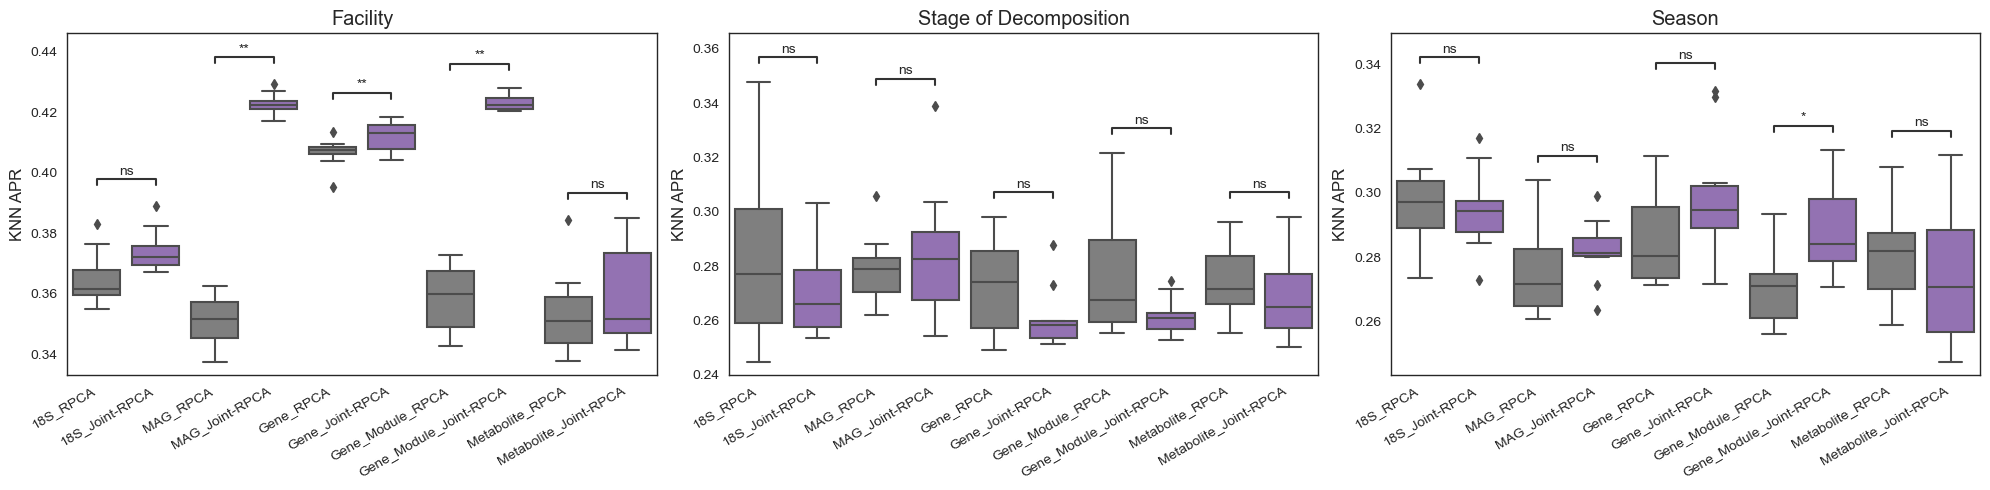

In [29]:
order_v1 = ['18S_RPCA', '18S_Joint-RPCA', 'MAG_RPCA', 'MAG_Joint-RPCA',
            'Gene_RPCA', 'Gene_Joint-RPCA', 'Gene_Module_RPCA', 'Gene_Module_Joint-RPCA',
            'Metabolite_RPCA', 'Metabolite_Joint-RPCA']
order_v2 = ["18S_RPCA", "MAG_RPCA", "Gene_RPCA", 
            "Gene_Module_RPCA", "Metabolite_RPCA",
            "18S_Joint-RPCA", "MAG_Joint-RPCA", "Gene_Joint-RPCA", 
            "Gene_Module_Joint-RPCA", "Metabolite_Joint-RPCA"]

stat_pairs = [('18S_RPCA', '18S_Joint-RPCA'), 
              ('MAG_RPCA', 'MAG_Joint-RPCA'),
              ('Gene_RPCA', 'Gene_Joint-RPCA'), 
              ('Gene_Module_RPCA', 'Gene_Module_Joint-RPCA'),
              ('Metabolite_RPCA', 'Metabolite_Joint-RPCA')]

pair_palette = {'18S_RPCA': 'tab:grey', '18S_Joint-RPCA': 'tab:purple',
                'MAG_RPCA': 'tab:grey', 'MAG_Joint-RPCA': 'tab:purple',
                'Gene_RPCA': 'tab:grey', 'Gene_Joint-RPCA': 'tab:purple',
                'Gene_Module_RPCA': 'tab:grey', 'Gene_Module_Joint-RPCA': 'tab:purple',
                'Metabolite_RPCA': 'tab:grey', 'Metabolite_Joint-RPCA': 'tab:purple'}

plotting_params = {'x':'Omic', 'y':'AUC_APR', 
                   'order':order_v1, 'palette':pair_palette}

fig, axn = plt.subplots(1, 3, figsize=(20, 5))

for ax_, data, title in zip(axn.flatten(), 
                           [apr_fts_avg_facility, apr_fts_avg_stage, apr_fts_avg_season],
                           ['Facility', 'Stage of Decomposition', 'Season']):
    
    plotting_params['data'] = data
    sns.boxplot(ax=ax_, **plotting_params)
    
    ax_.set_xticklabels(ax_.get_xticklabels(), rotation=30, ha='right')
    ax_.set_xlabel('')
    ax_.set_ylabel('KNN APR')
    ax_.set_title(title)

    #add statistical test
    annotator = Annotator(ax_, stat_pairs, **plotting_params)
    annotator.configure(test="Wilcoxon").apply_and_annotate()
    #test options: Mann-Whitney, Kruskal, Wilcoxon

plt.tight_layout()
plt.show()

### bottom features

In [150]:
#now we can apply the KNN classifier
#FACILITY
apr_bot_fts_facility = knn_apr(ord_tables=[rpca_bottom_fts['18S'], rpca_bottom_fts['mag'], rpca_bottom_fts['gene'],
                                           rpca_bottom_fts['gene_module'], rpca_bottom_fts['metabolite'],
                                           joint_rpca_bottom_fts['18S'], joint_rpca_bottom_fts['mag'], joint_rpca_bottom_fts['gene'],
                                           joint_rpca_bottom_fts['gene_module'], joint_rpca_bottom_fts['metabolite']],
                               ord_ids=["18S_RPCA", "MAG_RPCA", "Gene_RPCA", 
                                        "Gene_Module_RPCA", "Metabolite_RPCA",
                                        "18S_Joint-RPCA", "MAG_Joint-RPCA", "Gene_Joint-RPCA", 
                                        "Gene_Module_Joint-RPCA", "Metabolite_Joint-RPCA"],
                               shared_mt=metadata, cat_of_interest='facility')
#STAGE OF DECOMPOSITION
apr_bot_fts_stage = knn_apr(ord_tables=[rpca_bottom_fts['18S'], rpca_bottom_fts['mag'], rpca_bottom_fts['gene'],
                                        rpca_bottom_fts['gene_module'], rpca_bottom_fts['metabolite'],
                                        joint_rpca_bottom_fts['18S'], joint_rpca_bottom_fts['mag'], joint_rpca_bottom_fts['gene'],
                                        joint_rpca_bottom_fts['gene_module'], joint_rpca_bottom_fts['metabolite']],
                            ord_ids=["18S_RPCA", "MAG_RPCA", "Gene_RPCA", 
                                     "Gene_Module_RPCA", "Metabolite_RPCA",
                                     "18S_Joint-RPCA", "MAG_Joint-RPCA", "Gene_Joint-RPCA", 
                                     "Gene_Module_Joint-RPCA", "Metabolite_Joint-RPCA"],
                            shared_mt=metadata, cat_of_interest='add_0c_group')
#SEASON
apr_bot_fts_season = knn_apr(ord_tables=[rpca_bottom_fts['18S'], rpca_bottom_fts['mag'], rpca_bottom_fts['gene'],
                                         rpca_bottom_fts['gene_module'], rpca_bottom_fts['metabolite'],
                                         joint_rpca_bottom_fts['18S'], joint_rpca_bottom_fts['mag'], joint_rpca_bottom_fts['gene'],
                                         joint_rpca_bottom_fts['gene_module'], joint_rpca_bottom_fts['metabolite']],
                             ord_ids=["18S_RPCA", "MAG_RPCA", "Gene_RPCA", 
                                      "Gene_Module_RPCA", "Metabolite_RPCA",
                                      "18S_Joint-RPCA", "MAG_Joint-RPCA", "Gene_Joint-RPCA", 
                                      "Gene_Module_Joint-RPCA", "Metabolite_Joint-RPCA"],
                             shared_mt=metadata, cat_of_interest='season')

In [151]:
apr_bot_fts_avg_facility = pd.DataFrame(columns=['Fold', 'Omic', 'AUC_APR'])
apr_bot_fts_avg_stage = pd.DataFrame(columns=['Fold', 'Omic', 'AUC_APR'])
apr_bot_fts_avg_season = pd.DataFrame(columns=['Fold', 'Omic', 'AUC_APR'])

for fold_ in ['traintest_{}'.format(i) for i in range(10)]:
    avg1 = apr_bot_fts_facility[apr_bot_fts_facility['Fold'] == fold_].groupby('Omic').mean()
    apr_avg_fac = pd.DataFrame(zip([fold_]*10, avg1.index, avg1['AUC_APR']),
                               columns=['Fold', 'Omic', 'AUC_APR'])
    apr_bot_fts_avg_facility = pd.concat([apr_bot_fts_avg_facility, apr_avg_fac])

    avg2 = apr_bot_fts_stage[apr_bot_fts_stage['Fold'] == fold_].groupby('Omic').mean()
    apr_avg_st = pd.DataFrame(zip([fold_]*10, avg2.index, avg2['AUC_APR']),
                              columns=['Fold', 'Omic', 'AUC_APR'])
    apr_bot_fts_avg_stage = pd.concat([apr_bot_fts_avg_stage, apr_avg_st])

    avg3 = apr_bot_fts_season[apr_bot_fts_season['Fold'] == fold_].groupby('Omic').mean()
    apr_avg_se = pd.DataFrame(zip([fold_]*10, avg3.index, avg3['AUC_APR']),
                              columns=['Fold', 'Omic', 'AUC_APR'])
    apr_bot_fts_avg_season = pd.concat([apr_bot_fts_avg_season, apr_avg_se])


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

18S_RPCA vs. 18S_Joint-RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
MAG_RPCA vs. MAG_Joint-RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
Gene_RPCA vs. Gene_Joint-RPCA: Wilcoxon test (paired samples), P_val:1.953e-02 Stat=5.000e+00
Gene_Module_RPCA vs. Gene_Module_Joint-RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
Metabolite_RPCA vs. Metabolite_Joint-RPCA: Wilcoxon test (paired samples), P_val:3.223e-01 Stat=1.700e+01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

18S_RPCA vs. 18S_Joint-RPCA: Wilcoxon test (paired samples), P_val:5.566e-01 Stat=2.100e+01
MAG_RPCA vs. MAG_Joint-RPCA: Wil

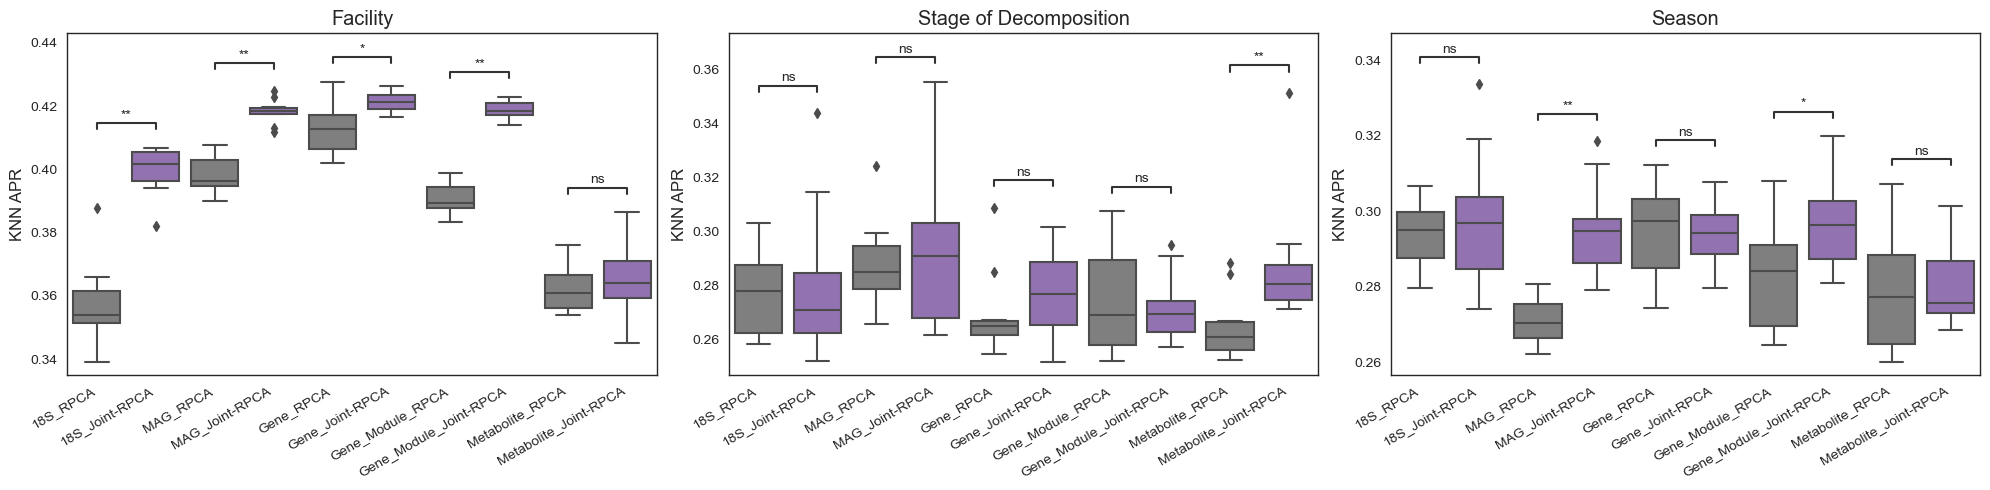

In [152]:
order_v1 = ['18S_RPCA', '18S_Joint-RPCA', 'MAG_RPCA', 'MAG_Joint-RPCA',
            'Gene_RPCA', 'Gene_Joint-RPCA', 'Gene_Module_RPCA', 'Gene_Module_Joint-RPCA',
            'Metabolite_RPCA', 'Metabolite_Joint-RPCA']

stat_pairs = [('18S_RPCA', '18S_Joint-RPCA'), 
              ('MAG_RPCA', 'MAG_Joint-RPCA'),
              ('Gene_RPCA', 'Gene_Joint-RPCA'), 
              ('Gene_Module_RPCA', 'Gene_Module_Joint-RPCA'),
              ('Metabolite_RPCA', 'Metabolite_Joint-RPCA')]

pair_palette = {'18S_RPCA': 'tab:grey', '18S_Joint-RPCA': 'tab:purple',
                'MAG_RPCA': 'tab:grey', 'MAG_Joint-RPCA': 'tab:purple',
                'Gene_RPCA': 'tab:grey', 'Gene_Joint-RPCA': 'tab:purple',
                'Gene_Module_RPCA': 'tab:grey', 'Gene_Module_Joint-RPCA': 'tab:purple',
                'Metabolite_RPCA': 'tab:grey', 'Metabolite_Joint-RPCA': 'tab:purple'}

plotting_params = {'x':'Omic', 'y':'AUC_APR', 
                   'order':order_v1, 'palette':pair_palette}

fig, axn = plt.subplots(1, 3, figsize=(20, 5))

for ax_, data, title in zip(axn.flatten(), 
                           [apr_bot_fts_avg_facility, apr_bot_fts_avg_stage, apr_bot_fts_avg_season],
                           ['Facility', 'Stage of Decomposition', 'Season']):
    
    plotting_params['data'] = data
    sns.boxplot(ax=ax_, **plotting_params)
    
    ax_.set_xticklabels(ax_.get_xticklabels(), rotation=30, ha='right')
    ax_.set_xlabel('')
    ax_.set_ylabel('KNN APR')
    ax_.set_title(title)

    #add statistical test
    annotator = Annotator(ax_, stat_pairs, **plotting_params)
    annotator.configure(test="Wilcoxon").apply_and_annotate()
    #test options: Mann-Whitney, Kruskal, Wilcoxon

plt.tight_layout()
plt.show()

### log-ratio

In [44]:
#common parameters
quantile = 0.90
pcs_to_use = ['PC1']

In [45]:
rpca_ord = {'18S': ord_18S, 'mag': ord_mag, 'gene': ord_gene, 
            'gene_module': ord_gene_module, 'metabolite': ord_metabolite}
rpca_top_fts = {}
rpca_bottom_fts = {}
rpca_traj = {}

for omic in tables.keys():

    ord_ = rpca_ord[omic].features.copy()
    table_ = tables[omic]

    top_fts, bottom_fts, beta_l = get_top_features(table_, ord_, component=pcs_to_use,
                                                   quantile=quantile, pseudocount=0)
    rpca_top_fts[omic] = top_fts
    rpca_bottom_fts[omic] = bottom_fts
    rpca_traj[omic] = beta_l

In [46]:
#find top features from joint-RPCA ordination results
joint_rpca_top_fts = {}
joint_rpca_bottom_fts = {}
joint_rpca_traj = {}

for omic in tables.keys():

    table_ = tables[omic]
    
    if omic == '18S':
        ord_ = joint_features.loc[in_ord_18S]
    else:
        ord_ = joint_features.loc[table_.ids(axis='observation')]

    top_fts, bottom_fts, beta_l = get_top_features(table_, ord_, component=pcs_to_use,
                                                   quantile=quantile, pseudocount=0)
    joint_rpca_top_fts[omic] = top_fts
    joint_rpca_bottom_fts[omic] = bottom_fts
    joint_rpca_traj[omic] = beta_l

In [47]:
#FACILITY
apr_traj_facility = knn_apr(ord_tables=[rpca_traj['18S'], rpca_traj['mag'], rpca_traj['gene'],
                                        rpca_traj['gene_module'], rpca_traj['metabolite'],
                                        joint_rpca_traj['18S'], joint_rpca_traj['mag'], joint_rpca_traj['gene'],
                                        joint_rpca_traj['gene_module'], joint_rpca_traj['metabolite']],
                            ord_ids=["18S_RPCA", "MAG_RPCA", "Gene_RPCA", 
                                     "Gene_Module_RPCA", "Metabolite_RPCA",
                                     "18S_Joint-RPCA", "MAG_Joint-RPCA", "Gene_Joint-RPCA", 
                                     "Gene_Module_Joint-RPCA", "Metabolite_Joint-RPCA"],
                            shared_mt=metadata, cat_of_interest='facility')
#STAGE OF DECOMPOSITION
apr_traj_stage = knn_apr(ord_tables=[rpca_traj['18S'], rpca_traj['mag'], rpca_traj['gene'],
                                     rpca_traj['gene_module'], rpca_traj['metabolite'],
                                     joint_rpca_traj['18S'], joint_rpca_traj['mag'], joint_rpca_traj['gene'],
                                     joint_rpca_traj['gene_module'], joint_rpca_traj['metabolite']],
                         ord_ids=["18S_RPCA", "MAG_RPCA", "Gene_RPCA", 
                                  "Gene_Module_RPCA", "Metabolite_RPCA",
                                  "18S_Joint-RPCA", "MAG_Joint-RPCA", "Gene_Joint-RPCA", 
                                  "Gene_Module_Joint-RPCA", "Metabolite_Joint-RPCA"],
                         shared_mt=metadata, cat_of_interest='add_0c_group')
#SEASON
apr_traj_season = knn_apr(ord_tables=[rpca_traj['18S'], rpca_traj['mag'], rpca_traj['gene'],
                                      rpca_traj['gene_module'], rpca_traj['metabolite'],
                                      joint_rpca_traj['18S'], joint_rpca_traj['mag'], joint_rpca_traj['gene'],
                                      joint_rpca_traj['gene_module'], joint_rpca_traj['metabolite']],
                          ord_ids=["18S_RPCA", "MAG_RPCA", "Gene_RPCA", 
                                  "Gene_Module_RPCA", "Metabolite_RPCA",
                                  "18S_Joint-RPCA", "MAG_Joint-RPCA", "Gene_Joint-RPCA", 
                                  "Gene_Module_Joint-RPCA", "Metabolite_Joint-RPCA"],
                          shared_mt=metadata, cat_of_interest='season')

In [48]:
apr_traj_avg_facility = pd.DataFrame(columns=['Fold', 'Omic', 'AUC_APR'])
apr_traj_avg_stage = pd.DataFrame(columns=['Fold', 'Omic', 'AUC_APR'])
apr_traj_avg_season = pd.DataFrame(columns=['Fold', 'Omic', 'AUC_APR'])

for fold_ in ['traintest_{}'.format(i) for i in range(10)]:
    avg1 = apr_traj_facility[apr_traj_facility['Fold'] == fold_].groupby('Omic').mean()
    apr_avg_fac = pd.DataFrame(zip([fold_]*10, avg1.index, avg1['AUC_APR']),
                               columns=['Fold', 'Omic', 'AUC_APR'])
    apr_traj_avg_facility = pd.concat([apr_traj_avg_facility, apr_avg_fac])

    avg2 = apr_traj_stage[apr_traj_stage['Fold'] == fold_].groupby('Omic').mean()
    apr_avg_st = pd.DataFrame(zip([fold_]*10, avg2.index, avg2['AUC_APR']),
                              columns=['Fold', 'Omic', 'AUC_APR'])
    apr_traj_avg_stage = pd.concat([apr_traj_avg_stage, apr_avg_st])

    avg3 = apr_traj_season[apr_traj_season['Fold'] == fold_].groupby('Omic').mean()
    apr_avg_se = pd.DataFrame(zip([fold_]*10, avg3.index, avg3['AUC_APR']),
                              columns=['Fold', 'Omic', 'AUC_APR'])
    apr_traj_avg_season = pd.concat([apr_traj_avg_season, apr_avg_se])


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

18S_RPCA vs. 18S_Joint-RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
MAG_RPCA vs. MAG_Joint-RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
Gene_RPCA vs. Gene_Joint-RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
Gene_Module_RPCA vs. Gene_Module_Joint-RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
Metabolite_RPCA vs. Metabolite_Joint-RPCA: Wilcoxon test (paired samples), P_val:2.734e-02 Stat=6.000e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

18S_RPCA vs. 18S_Joint-RPCA: Wilcoxon test (paired samples), P_val:8.398e-02 Stat=1.000e+01
MAG_RPCA vs. MAG_Joint-RPCA: Wil

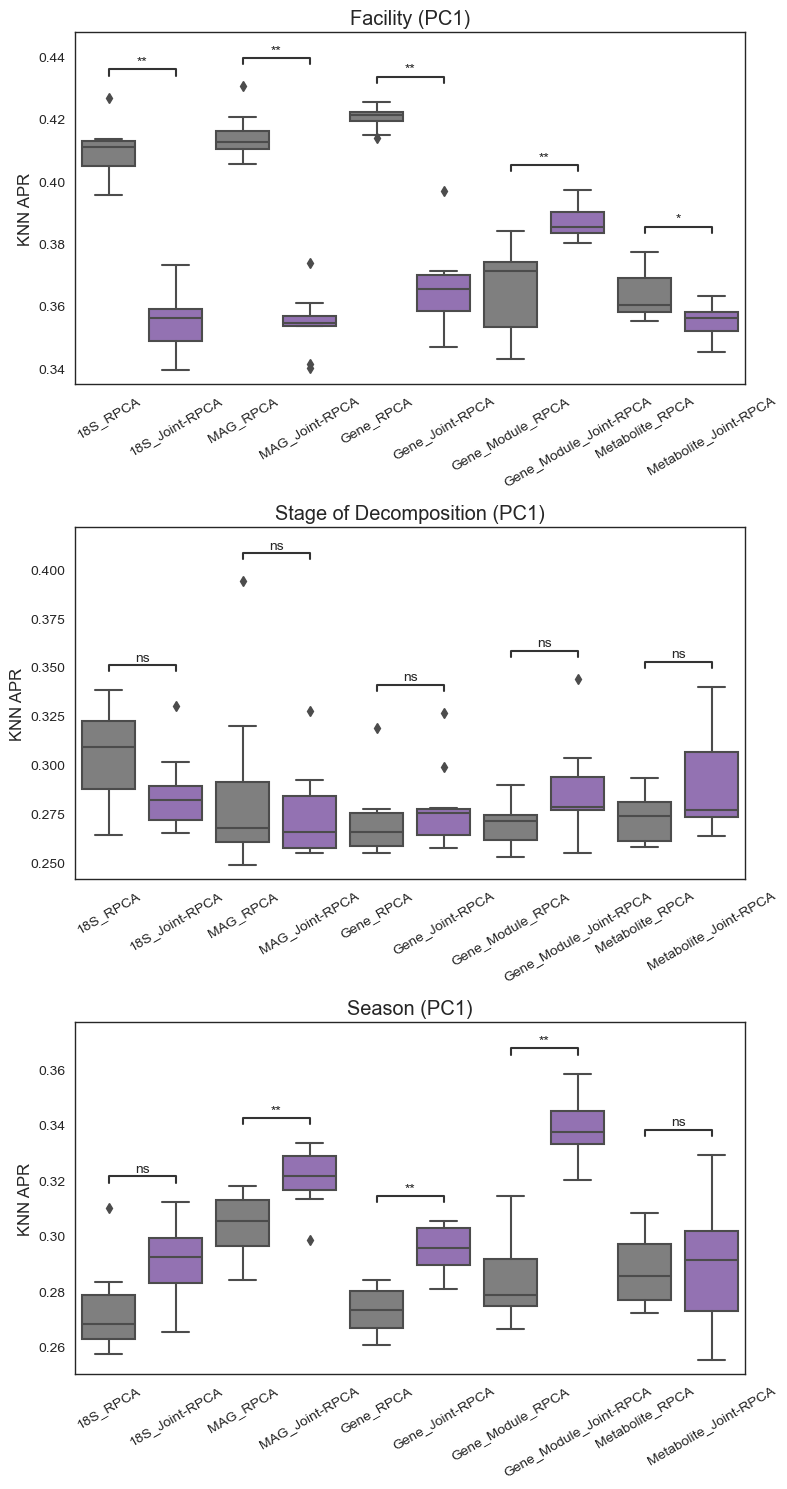

In [49]:
order_v1 = ['18S_RPCA', '18S_Joint-RPCA', 'MAG_RPCA', 'MAG_Joint-RPCA',
            'Gene_RPCA', 'Gene_Joint-RPCA', 'Gene_Module_RPCA', 'Gene_Module_Joint-RPCA',
            'Metabolite_RPCA', 'Metabolite_Joint-RPCA']

stat_pairs = [('18S_RPCA', '18S_Joint-RPCA'), 
              ('MAG_RPCA', 'MAG_Joint-RPCA'),
              ('Gene_RPCA', 'Gene_Joint-RPCA'), 
              ('Gene_Module_RPCA', 'Gene_Module_Joint-RPCA'),
              ('Metabolite_RPCA', 'Metabolite_Joint-RPCA')]

pair_palette = {'18S_RPCA': 'tab:grey', '18S_Joint-RPCA': 'tab:purple',
                'MAG_RPCA': 'tab:grey', 'MAG_Joint-RPCA': 'tab:purple',
                'Gene_RPCA': 'tab:grey', 'Gene_Joint-RPCA': 'tab:purple',
                'Gene_Module_RPCA': 'tab:grey', 'Gene_Module_Joint-RPCA': 'tab:purple',
                'Metabolite_RPCA': 'tab:grey', 'Metabolite_Joint-RPCA': 'tab:purple'}

plotting_params = {'x':'Omic', 'y':'AUC_APR', 
                   'order':order_v1, 'palette':pair_palette}

fig, axn = plt.subplots(3, 1, figsize=(8, 15))

for ax_, data, title in zip(axn.flatten(), 
                           [apr_traj_avg_facility, apr_traj_avg_stage, apr_traj_avg_season],
                           ['Facility', 'Stage of Decomposition', 'Season']):
    
    plotting_params['data'] = data
    sns.boxplot(ax=ax_, **plotting_params)
    
    ax_.set_xticklabels(ax_.get_xticklabels(), rotation=30)
    ax_.set_xlabel('')
    ax_.set_ylabel('KNN APR')
    ax_.set_title('{} ({})'.format(title, pcs_to_use[0]))

    #add statistical test
    annotator = Annotator(ax_, stat_pairs, **plotting_params)
    annotator.configure(test="Wilcoxon").apply_and_annotate()
    #test options: Mann-Whitney, Kruskal, Wilcoxon

plt.tight_layout()
plt.show()